# Import Libraries

In [12]:
import numpy as np
import importlib
import pickle
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import torch

# Imports own modules.
#
import loadforecasting_framework.case_study.optimize_bess as optimize_bess
from loadforecasting_framework import utils
import loadforecasting_framework.simulation_config as simulation_config
from loadforecasting_framework.simulation_config import *


# Import Price Signal

In [13]:
# Import energy price in €/Wh
#
with open('../../../data/exaa_prices_1h.pkl', 'rb') as f:
    price_signal = pickle.load(f)


# Import last Load Forecasts

In [ ]:
# Import electrical load forecast in W
#
importlib.reload(utils)
importlib.reload(simulation_config)

########
# Setup the test setup configuration
#
resuts_filename = '../outputs/all_train_histories.pkl'
expected_configs = [
    ConfigOfOneRun(Model.SIZE_5k, DoPretraining.YES, DoTransferLearning.YES, AggregationCount.
        ONE_HOUSEHOLD, NrOfComunities.TWENTY, TrainSet1.PAST_12_MONTH, TestSize.NEXT_3_MONTH,
        TrainSet2.FUTURE_0_MONTH, DevSize.NEXT_2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    ConfigOfOneRun(Model.SIZE_5k, DoPretraining.YES, DoTransferLearning.YES, AggregationCount.
        TWO_HOUSEHOLDS, NrOfComunities.TWENTY, TrainSet1.PAST_12_MONTH, TestSize.NEXT_3_MONTH,
        TrainSet2.FUTURE_0_MONTH, DevSize.NEXT_2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    ConfigOfOneRun(Model.SIZE_5k, DoPretraining.YES, DoTransferLearning.YES, AggregationCount.
        TEN_HOUSEHOLDS, NrOfComunities.TWENTY, TrainSet1.PAST_12_MONTH, TestSize.NEXT_3_MONTH,
        TrainSet2.FUTURE_0_MONTH, DevSize.NEXT_2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    ConfigOfOneRun(Model.SIZE_5k, DoPretraining.YES, DoTransferLearning.YES, AggregationCount.
        FIFTY_HOUSEHOLDS, NrOfComunities.TWENTY, TrainSet1.PAST_12_MONTH, TestSize.NEXT_3_MONTH,
        TrainSet2.FUTURE_0_MONTH, DevSize.NEXT_2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    ConfigOfOneRun(Model.SIZE_5k, DoPretraining.YES, DoTransferLearning.YES, AggregationCount.
        HUNDRED_HOUSEHOLDS, NrOfComunities.TWENTY, TrainSet1.PAST_12_MONTH, TestSize.NEXT_3_MONTH,
        TrainSet2.FUTURE_0_MONTH, DevSize.NEXT_2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    ]
########

# Check, if all data are available
# and create a nested dictionary of shape 'profiles_by_community_size[community_size][model][community_id]'
#
profiles_by_community_size = utils.Evaluate_Models.get_testrun_results(expected_configs, resuts_filename)


## MILP Optimization

In [16]:
importlib.reload(optimize_bess)

# Run the MILP optimziation for all communities and model sizes.
#
costs_per_community_size = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for community_size, profiles_per_model in profiles_by_community_size.items():
    for model_name, profiles_per_community in profiles_per_model.items():        
        
        print(f'\nOptimize community size {community_size} with model "{model_name}"')
        
        if model_name == 'Perfect':
            buffer_size = 0.0
        else:
            buffer_size = 0.15      
        
        for community_id, profile in enumerate(profiles_per_community):
            perfect_prediction = profiles_per_model['Perfect'][community_id]
            myOptimization = optimize_bess.OptimizeBess(
                profile, 
                community_size, 
                price_signal, 
                perfect_prediction,
                buffer_size = buffer_size
                )
            print(f' {community_id}', end='')
            optimization_result = myOptimization.run()
            costs_per_community_size[community_size][model_name][community_id] = optimization_result



Optimize community size 1 with model "Perfect"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize community size 1 with model "Knn"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize community size 1 with model "Persistence"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize community size 1 with model "xLstm"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize community size 1 with model "Lstm"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize community size 1 with model "Transformer"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize community size 2 with model "Perfect"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize community size 2 with model "Knn"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize community size 2 with model "Persistence"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize community size 2 with model "xLstm"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize community siz

# Evaluation (Print Latex Table)

In [17]:
# Calc the normalized mean absolut error:
#
def calc_nMAE(Y_perfect, Y_model):
    loss_fn = torch.nn.L1Loss()
    Y_perfect = torch.Tensor(Y_perfect)
    Y_model = torch.Tensor(Y_model)
    loss = loss_fn(Y_perfect, Y_model)
    reference = float(torch.mean(Y_perfect))
    nMAE = 100.0 * loss / reference
    return float(nMAE)

In [18]:
# Print all Results in a Latex Table
#
results_per_community_size = []
for nr_of_households, costs_per_model in costs_per_community_size.items():
        
    # Calculate the average costs without optimization
    reference_costs = []
    perfect_profiles = profiles_by_community_size[nr_of_households]['Perfect']
    for perfect_profile in perfect_profiles:
        assert price_signal.shape == perfect_profile.shape, "Arrays must be the same shape"
        assert price_signal.ndim == 1, "price_signal must be a 1D array"
        costs = np.sum(price_signal * perfect_profile)
        reference_costs.append(costs)
    avg_reference_costs = np.mean(reference_costs)
    
    if nr_of_households == 1:
        column_name = f'{nr_of_households} Household'
    else:
        column_name = f'{nr_of_households} Households'        
    
    # Store the result
    results_per_community_size.append({
            "Community Size": column_name,
            "Model": 'Unoptimized',
            "nMAE (%)": '',
            "Costs (€)": round(avg_reference_costs, 2),
            "Savings (€)": '',
            "Savings (%)": ''
        })
    
    for model_name, costs_per_community in costs_per_model.items():

        # Calc the average costs with optimization per model over all communities
        all_costs = list(costs_per_community.values())
        costs_avg = np.mean(all_costs)
        savings_avg = np.mean([(avg_reference_costs - costs) for costs in all_costs])
        savings_percent_avg = np.mean([100*(avg_reference_costs - costs)/avg_reference_costs for costs in all_costs])
        profile_per_community = profiles_by_community_size[nr_of_households][model_name]
        nMAE_avg = np.mean([calc_nMAE(perfect_profiles[i], profile)
                            for i, profile in enumerate(profile_per_community)])

        results_per_community_size.append({
            "Community Size": column_name,
            "Model": model_name,
            "nMAE (%)": round(nMAE_avg, 2),
            "Costs (€)": round(costs_avg, 2),
            "Savings (€)": round(savings_avg, 2),
            "Savings (%)": round(savings_percent_avg, 2)
        })

# Print the dataframe in latex
#
df = pd.DataFrame(results_per_community_size)
df["Community Size"] = df["Community Size"].mask(df["Community Size"].duplicated(), "")
latex = df.to_latex(index=False, float_format="%.2f")
lines = latex.splitlines()
new_lines = []
row_counter = 0
for i, line in enumerate(lines):
    new_lines.append(line)
    if line.endswith(r"\\") and i > 3 and not line.strip().startswith(r"\midrule"):
        row_counter += 1
        if row_counter % 7 == 0:
            new_lines.append(r"\midrule")
latex_modified = "\n".join(new_lines)
print(latex_modified)


\begin{tabular}{lllrll}
\toprule
Community Size & Model & nMAE (%) & Costs (€) & Savings (€) & Savings (%) \\
\midrule
1 Household & Unoptimized &  & 299.06 &  &  \\
 & Perfect & 0.00 & 280.65 & 18.41 & 6.16 \\
 & Knn & 53.84 & 292.77 & 6.29 & 2.10 \\
 & Persistence & 57.25 & 294.76 & 4.30 & 1.44 \\
 & xLstm & 47.92 & 289.93 & 9.13 & 3.05 \\
 & Lstm & 50.69 & 290.75 & 8.30 & 2.78 \\
 & Transformer & 48.46 & 290.07 & 8.99 & 3.01 \\
\midrule
2 Households & Unoptimized &  & 495.71 &  &  \\
 & Perfect & 0.00 & 456.94 & 38.78 & 7.82 \\
 & Knn & 39.04 & 474.73 & 20.98 & 4.23 \\
 & Persistence & 44.98 & 478.09 & 17.62 & 3.55 \\
 & xLstm & 35.47 & 470.67 & 25.04 & 5.05 \\
 & Lstm & 37.02 & 472.53 & 23.19 & 4.68 \\
 & Transformer & 35.70 & 471.21 & 24.51 & 4.94 \\
\midrule
10 Households & Unoptimized &  & 2218.93 &  &  \\
 & Perfect & 0.00 & 2019.64 & 199.28 & 8.98 \\
 & Knn & 21.63 & 2058.95 & 159.97 & 7.21 \\
 & Persistence & 24.86 & 2070.55 & 148.38 & 6.69 \\
 & xLstm & 20.46 & 2055.15 & 163

# Evaluation (Plot Figure)

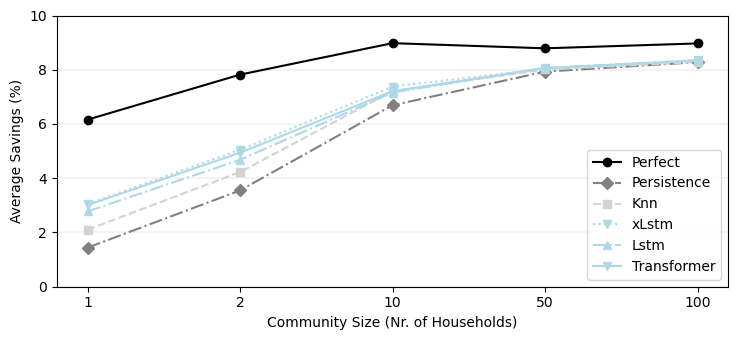

In [22]:
# todo: refactoring. 

# Create dataframe for plotting
df = pd.DataFrame(results_per_community_size)
pivot_df = df.pivot(index='Community Size', columns='Model', values='Savings (%)')
pivot_df = pivot_df[['Perfect', 'Persistence', 'Knn', 'xLstm', 'Lstm', 'Transformer']]
pivot_df = pivot_df.reindex(['1 Household', '2 Households', '10 Households', '50 Households', '100 Households', ])
categories = pivot_df.index
subgroups = pivot_df.columns

# Create the plot
fig_width_inch = 190 / 25.4
fig_height_inch = 3.5
fig, ax = plt.subplots(figsize=(fig_width_inch, fig_height_inch))
x = np.arange(len(categories))  # label locations
width = 0.1  # width of the bars
colors=['black', 'grey', 'lightgrey', 'lightblue', 'lightblue', 'lightblue']
format=['o-', 'D-.', 's--', 'v:', '^-.', 'v-']
for i, subgroup in enumerate(subgroups):
    ax.plot(x, pivot_df[subgroup], format[i], label=subgroup, color=colors[i])
ax.set_ylabel('Average Savings (%)')
ax.grid(axis='y', linestyle='-', linewidth=0.2, zorder=0)
ax.set_ylim(0, 10)
ax.set_xlim(None, None)
ax.set_xticks(x)
ax.set_xticklabels(['1', '2', '10', '50', '100'])
plt.xlabel("Community Size (Nr. of Households)")
ax.legend()
plt.tight_layout()
plt.savefig('../outputs/figs/Figure_14a.pdf', format='pdf', bbox_inches='tight')
plt.show()


# Optimize and Evaluate different Battery Sizes

In [23]:
importlib.reload(optimize_bess)

# Run the MILP optimziation for all communities and model sizes.
#
costs_per_battery_size = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

community_size = 10
battery_sizes = [5000, 50000, 100000, 150000, 200000]
for battery_size in battery_sizes:
    for model_name, profiles_per_community in profiles_by_community_size[community_size].items():        
        
        print(f'\nOptimize battery size {battery_size} with model "{model_name}"')
        
        if model_name == 'Perfect':
            buffer_size = 0.0
        else:
            buffer_size = 0.15      
        
        for community_id, profile in enumerate(profiles_per_community):
            perfect_prediction = profiles_by_community_size[community_size]['Perfect'][community_id]
            myOptimization = optimize_bess.OptimizeBess(
                profile, 
                community_size, 
                price_signal, 
                perfect_prediction,
                buffer_size = buffer_size,
                battery_size = battery_size
                )
            print(f' {community_id}', end='')
            optimization_result = myOptimization.run()
            costs_per_battery_size[battery_size][model_name][community_id] = optimization_result
    


Optimize battery size 5000 with model "Perfect"
 0

 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize battery size 5000 with model "Knn"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize battery size 5000 with model "Persistence"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize battery size 5000 with model "xLstm"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize battery size 5000 with model "Lstm"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize battery size 5000 with model "Transformer"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize battery size 50000 with model "Perfect"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize battery size 50000 with model "Knn"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize battery size 50000 with model "Persistence"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize battery size 50000 with model "xLstm"
 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Optimize battery size 50000 with model "Lstm"
 0 1 2 3 4 5 

In [24]:
# Print all Results in a Latex Table
#
results_per_battery_size = []
for battery_size, costs_per_model in costs_per_battery_size.items():

    # Calculate the average costs without optimization
    reference_costs = []
    perfect_profiles = profiles_by_community_size[community_size]['Perfect']
    for perfect_profile in perfect_profiles:
        assert price_signal.shape == perfect_profile.shape, "Arrays must be the same shape"
        assert price_signal.ndim == 1, "price_signal must be a 1D array"
        costs = np.sum(price_signal * perfect_profile)
        reference_costs.append(costs)
    avg_reference_costs = np.mean(reference_costs)    
    
    # Store the result
    results_per_battery_size.append({
            "Battery Size": f'{battery_size/1000:.0f} kWh',
            "Model": 'Unoptimized',
            "nMAE (%)": '',
            "Costs (€)": round(avg_reference_costs, 2),
            "Savings (€)": '',
            "Savings (%)": ''
        })
    
    for model_name, costs_per_community in costs_per_model.items():

        # Calc the average costs with optimization per model over all communities
        all_costs = list(costs_per_community.values())
        costs_avg = np.mean(all_costs)
        savings_avg = np.mean([(avg_reference_costs - costs) for costs in all_costs])
        savings_percent_avg = np.mean([100*(avg_reference_costs - costs)/avg_reference_costs for costs in all_costs])
        profile_per_community = profiles_by_community_size[community_size][model_name]
        nMAE_avg = np.mean([calc_nMAE(perfect_profiles[i], profile)
                            for i, profile in enumerate(profile_per_community)])

        results_per_battery_size.append({
            "Battery Size": f'{battery_size/1000:.0f} kWh',
            "Model": model_name,
            "nMAE (%)": round(nMAE_avg, 2),
            "Costs (€)": round(costs_avg, 2),
            "Savings (€)": round(savings_avg, 2),
            "Savings (%)": round(savings_percent_avg, 2)
        })

# Print the dataframe in latex
#
df = pd.DataFrame(results_per_battery_size)
df["Battery Size"] = df["Battery Size"].mask(df["Battery Size"].duplicated(), "")
latex = df.to_latex(index=False, float_format="%.2f")
lines = latex.splitlines()
new_lines = []
row_counter = 0
for i, line in enumerate(lines):
    new_lines.append(line)
    if line.endswith(r"\\") and i > 3 and not line.strip().startswith(r"\midrule"):
        row_counter += 1
        if row_counter % 7 == 0:
            new_lines.append(r"\midrule")
latex_modified = "\n".join(new_lines)
print(latex_modified)



\begin{tabular}{lllrll}
\toprule
Battery Size & Model & nMAE (%) & Costs (€) & Savings (€) & Savings (%) \\
\midrule
5 kWh & Unoptimized &  & 2218.93 &  &  \\
 & Perfect & 0.00 & 2208.29 & 10.64 & 0.48 \\
 & Knn & 21.63 & 2208.29 & 10.64 & 0.48 \\
 & Persistence & 24.86 & 2208.29 & 10.64 & 0.48 \\
 & xLstm & 20.46 & 2208.29 & 10.64 & 0.48 \\
 & Lstm & 21.03 & 2208.29 & 10.64 & 0.48 \\
 & Transformer & 20.70 & 2208.29 & 10.64 & 0.48 \\
\midrule
50 kWh & Unoptimized &  & 2218.93 &  &  \\
 & Perfect & 0.00 & 2115.80 & 103.13 & 4.65 \\
 & Knn & 21.63 & 2126.86 & 92.07 & 4.15 \\
 & Persistence & 24.86 & 2128.54 & 90.39 & 4.07 \\
 & xLstm & 20.46 & 2125.33 & 93.60 & 4.22 \\
 & Lstm & 21.03 & 2127.02 & 91.91 & 4.14 \\
 & Transformer & 20.70 & 2127.21 & 91.72 & 4.13 \\
\midrule
100 kWh & Unoptimized &  & 2218.93 &  &  \\
 & Perfect & 0.00 & 2041.77 & 177.15 & 7.98 \\
 & Knn & 21.63 & 2074.64 & 144.28 & 6.50 \\
 & Persistence & 24.86 & 2084.62 & 134.31 & 6.05 \\
 & xLstm & 20.46 & 2071.54 & 147

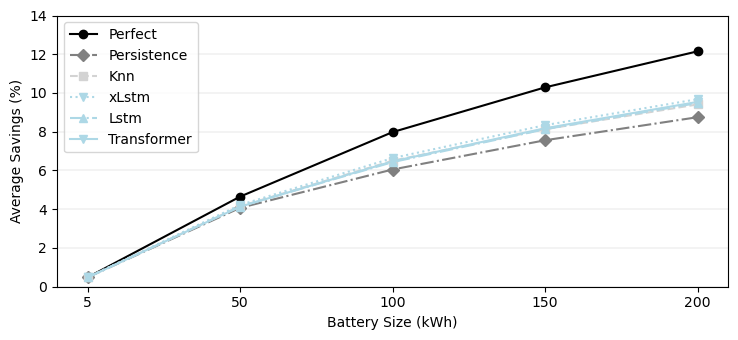

In [27]:
# Create dataframe for plotting
df = pd.DataFrame(results_per_battery_size)
pivot_df = df.pivot(index='Battery Size', columns='Model', values='Savings (%)')
pivot_df = pivot_df[['Perfect', 'Persistence', 'Knn', 'xLstm', 'Lstm', 'Transformer']] # Filter 
pivot_df = pivot_df.reindex(['5 kWh', '50 kWh', '100 kWh', '150 kWh', '200 kWh'])
categories = pivot_df.index
subgroups = pivot_df.columns

# Create the plot
fig_width_inch = 190 / 25.4
fig_height_inch = 3.5
fig, ax = plt.subplots(figsize=(fig_width_inch, fig_height_inch))
x = np.arange(len(categories))  # label locations
colors=['black', 'grey', 'lightgrey', 'lightblue', 'lightblue', 'lightblue']
format=['o-', 'D-.', 's--', 'v:', '^-.', 'v-']
for i, subgroup in enumerate(subgroups):
    ax.plot(x, pivot_df[subgroup], format[i], label=subgroup, color=colors[i])
ax.grid(axis='y', linestyle='-', linewidth=0.2, zorder=0)
ax.set_ylabel('Average Savings (%)')
ax.set_ylim(0, 14)
ax.set_xlim(None, None)
ax.set_xticks(x)
ax.set_xticklabels(['5', '50', '100', '150', '200'])
plt.xlabel("Battery Size (kWh)")
ax.legend()
plt.tight_layout()
plt.savefig('../outputs/figs/Figure_14b.pdf', format='pdf', bbox_inches='tight')
plt.show()
